# EDA를 통해 선별한 Validation dataset EDA
이 노트북을 토아혀 data EDA으로 선별한 검증 데이터를 탐색합니다.

In [53]:
import json
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from scipy.stats import norm
import math
from pycocotools.coco import COCO

In [54]:
class_colors = {
    0: '#FF0000',
    1: '#0000FF',
    2: '#F0F000',
    3: '#00FF00',
    4: '#800080',
    5: '#FFC0CB',
    6: '#FFA500',
    7: '#87CEEB',
    8: '#808080',
    9: '#A52A2A'
}

In [55]:
path_train = '/data/ephemeral/home/level2-objectdetection-cv-08/data/recycle/train_eye_eda.json'
path_val = '/data/ephemeral/home/level2-objectdetection-cv-08/data/recycle/val_eye_eda.json'
# Load train.json file
coco_train = COCO(path_train)
coco_val = COCO(path_val)

categories = coco_train.loadCats(coco_train.getCatIds())

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [56]:
def visualize_class_counts(class_counts, class_colors,categories,name):
    sorted_class_ids = sorted(class_counts.keys())
    class_names = [categories[i]['name'] for i in sorted_class_ids]
    counts = [class_counts[i] for i in sorted_class_ids]
    colors = [class_colors[i] for i in sorted_class_ids]

    plt.bar(class_names, counts, color=colors)
    plt.ylabel('Count')
    name = 'Class counts '+ name + ' Total: '+str(sum(counts))
    plt.title(name)
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()
    plt.show()

In [57]:
def analyze_class(coco):
    class_counts = {}

    for img_id in coco.imgs:
        ann_ids = coco.getAnnIds(imgIds=[img_id])
        annotations = coco.loadAnns(ann_ids)

        for annotation in annotations:
            class_id = annotation['category_id']
            class_counts[class_id] = class_counts.get(class_id, 0) + 1
    return class_counts

class_counts_train = analyze_class(coco_train)
class_counts_val = analyze_class(coco_val)

sorted_class_ids = sorted(class_counts_train.keys())
class_names = [categories[i]['name'] for i in sorted_class_ids]
counts_train = [class_counts_train[i] for i in sorted_class_ids]
colors = [class_colors[i] for i in sorted_class_ids]
counts_val = [class_counts_val[i] for i in sorted_class_ids]

### train, validation 클래스 분포

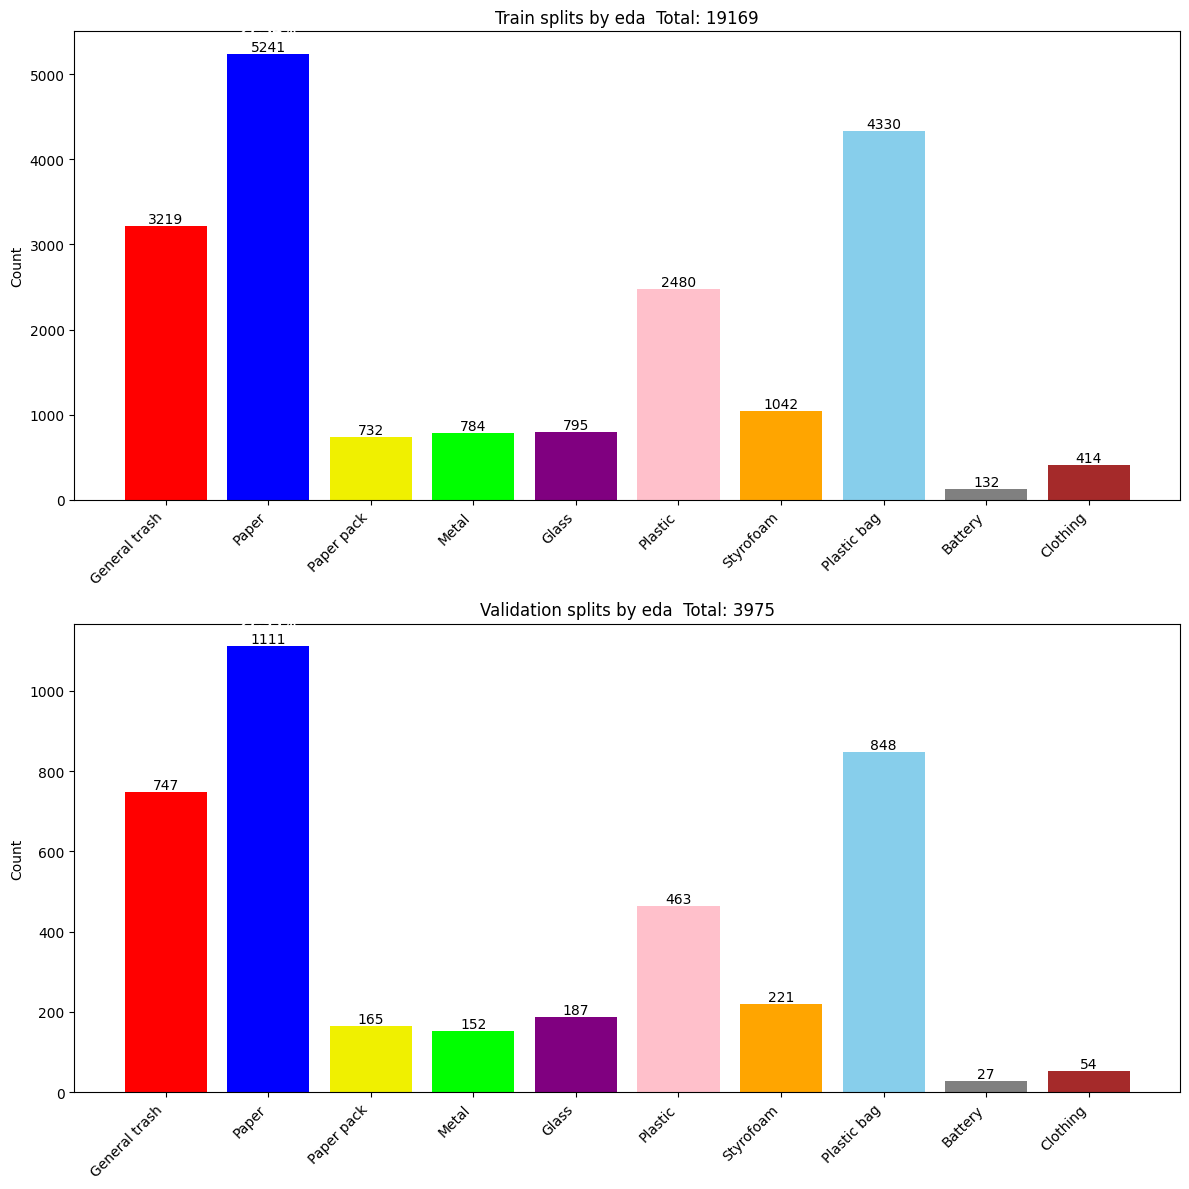

In [58]:
def draw_bar_graph(class_names, counts, colors, title, total_samples):
    plt.bar(class_names, counts, color=colors)
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')

    for i, count in enumerate(counts):
        percentage = (count / total_samples) * 100
        plt.text(i, count, f'{count}', ha='center', va='bottom')
        plt.text(i, count + (total_samples * 0.01), f'{percentage:.2f}%', ha='center', va='bottom', color='white', fontweight='bold')

plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
total_train_samples = sum(counts_train)
train_title = 'Train splits by eda ' + ' Total: ' + str(total_train_samples)
draw_bar_graph(class_names, counts_train, colors, train_title, total_train_samples)

plt.subplot(2, 1, 2)
total_val_samples = sum(counts_val)
val_title = 'Validation splits by eda ' + ' Total: ' + str(total_val_samples)
draw_bar_graph(class_names, counts_val, colors, val_title, total_val_samples)

plt.tight_layout()
plt.show()


### bbox area 별 validation data 분포

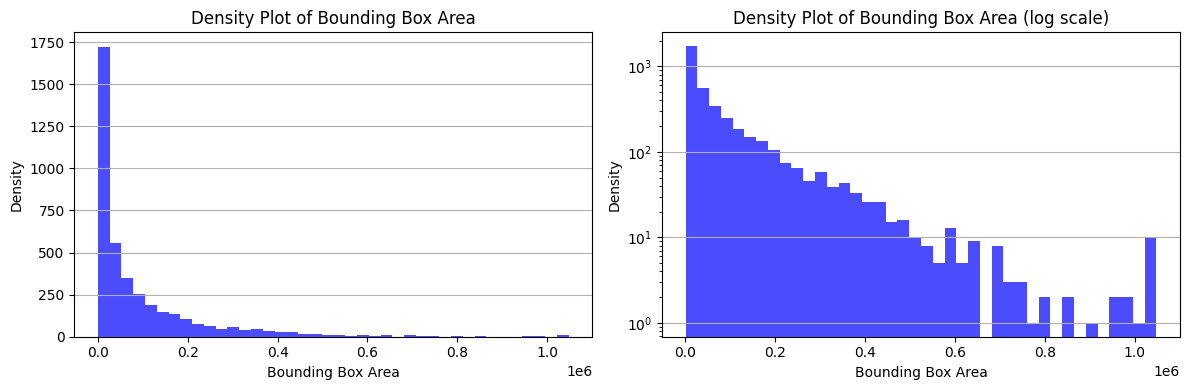

In [59]:
def analyze_bbox_area(coco):
    bbox_areas = []

    for img_id in coco.imgs:
        ann_ids = coco.getAnnIds(imgIds=[img_id])
        annotations = coco.loadAnns(ann_ids)

        for annotation in annotations:
            bbox_areas.append(annotation['area'])
    return bbox_areas

def draw_histogram(data, subplot_index, yscale='linear', title=''):
    plt.subplot(1, 2, subplot_index) 
    plt.hist(data, bins=40, alpha=0.7, color='blue')
    plt.xlabel('Bounding Box Area')
    plt.ylabel('Density')
    plt.title(title)
    plt.grid(axis='y')
    plt.yscale(yscale)

bbox_areas = analyze_bbox_area(coco_val)

plt.figure(figsize=(12, 4))
draw_histogram(bbox_areas, 1, 'linear', 'Density Plot of Bounding Box Area')
draw_histogram(bbox_areas, 2, 'log', 'Density Plot of Bounding Box Area (log scale)')
plt.tight_layout()  
plt.show()


### 각 클래스 별 width, height 산점도

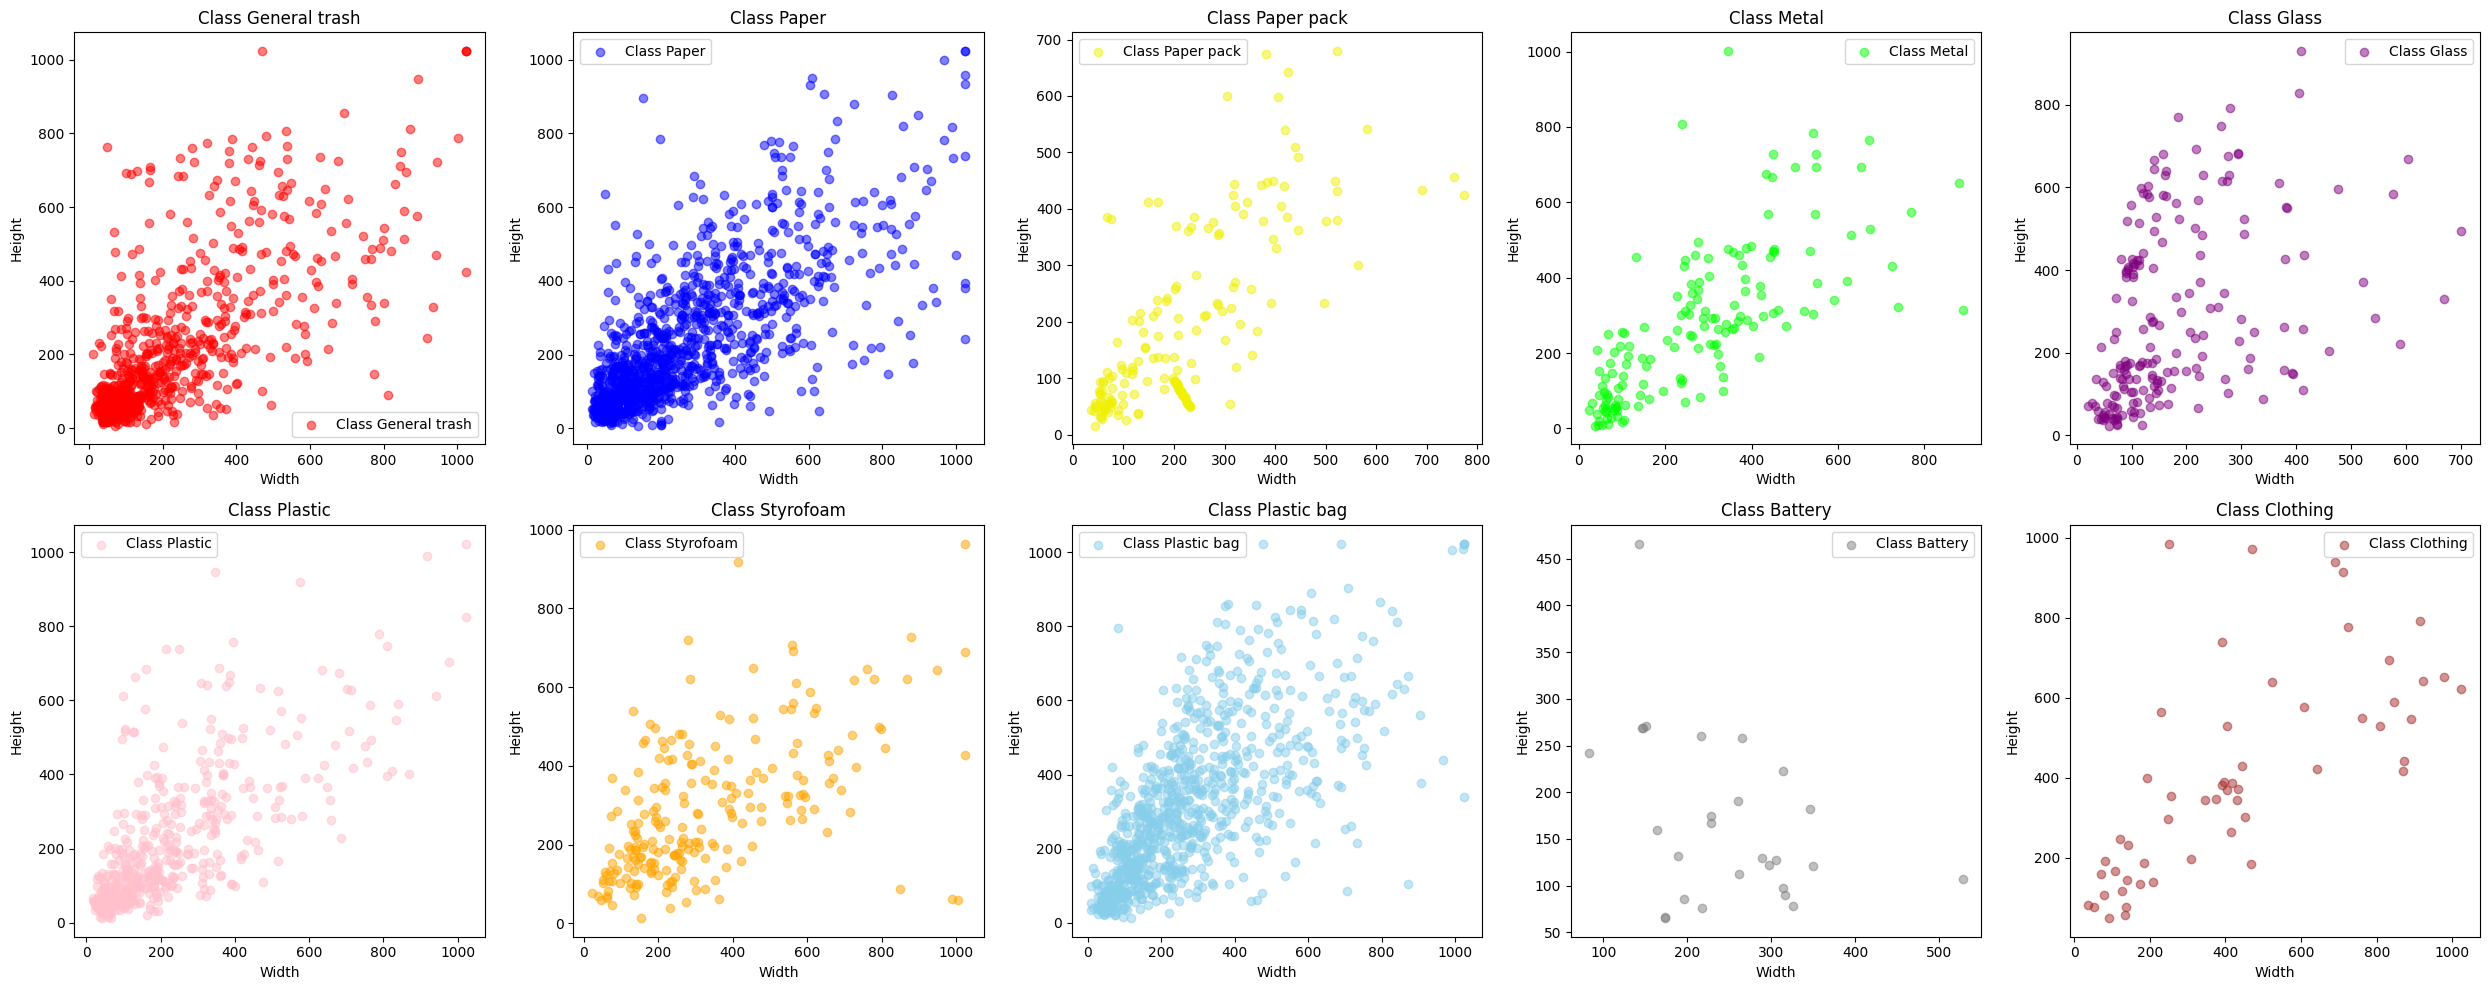

In [60]:
def collect_bbox_dimensions(coco_dataset):
    class_dimensions = {class_id: {'widths': [], 'heights': []} for class_id in class_colors}
    for annotation_id in coco_dataset.getAnnIds():
        annotation = coco_dataset.loadAnns(annotation_id)[0]
        class_id = annotation['category_id']
        bbox_width = annotation['bbox'][2]
        bbox_height = annotation['bbox'][3]
        class_dimensions[class_id]['widths'].append(bbox_width)
        class_dimensions[class_id]['heights'].append(bbox_height)
    return class_dimensions

def draw_scatter_plot(axes, class_id, dimensions, class_name, class_color):
    ax = axes[class_id]
    ax.scatter(dimensions['widths'], dimensions['heights'], color=class_color, alpha=0.5)
    ax.set_title(f'Class {class_name}')
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    ax.legend([f'Class {class_name}'])

class_dimensions = collect_bbox_dimensions(coco_val)

fig, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.flatten()

for class_id, dimensions in class_dimensions.items():
    draw_scatter_plot(axes, class_id, dimensions, class_names[class_id], class_colors[class_id])

plt.tight_layout()
plt.show()

